# Set up

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../src/'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

/Volumes/GoogleDrive/My Drive/USC/Projects/210913-FiberNET/211025-Exp3-ConvVAE/src


In [18]:
import glob
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from tqdm.auto import tqdm
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

import dipy
from dipy.viz import window, actor

from data.SubjData import *
from data.data_util import *
from utils.general_util import *
from model.model import *
from model.train_model import train_model
from evaluation import *

In [3]:
SEED = 2022
set_seed(seed=SEED)
DEVICE = set_device()
if DEVICE == 'cuda':
    print(torch.cuda.device_count(), 
          torch.cuda.get_device_name(0))

Random seed 2022 has been set.
GPU is not enabled in this notebook.


In [4]:
model_folder = "../results/models/"
plot_folder = "../results/plots/"
result_data_folder = "../results/data/"
log_folder = "../results/logs/"
data_files_folder = "../data_files/"

# change these if running locally
data_folder = "../../211105-DATA_ADNI3_DWI/"

# Load data

In [5]:
args = {'n_points' : 256, 'n_lines' : None, 'min_lines' : 2, 
        'tracts_exclude' : ['CST_L_s', 'CST_R_s'],'preprocess' : '3d', 
        'rng' : np.random.RandomState(SEED), 'verbose': False, 
        'data_folder' : data_folder}

subj_train = SubjData('007_S_6120_20171117_A3_DWI_S127', **args)

Loaded 007_S_6120_20171117_A3_DWI_S127 with 30 tracts and 51062 lines.


In [6]:
print(subj_train.X.shape, subj_train.y.shape)

(51062, 256, 3) (51062,)


# Dataset & Dataloader

Preprocess data into torch Dataset and Dataloader

In [7]:
'''This is the data for training or is train on'''
X = subj_train.X
y = subj_train.y

In [8]:
'''Split into train and test 80/20'''
train, test = split_data(X, y)
X_train = torch.from_numpy(X[train])
y_train = torch.from_numpy(y[train])
X_test = torch.from_numpy(X[test])
y_test = torch.from_numpy(y[test])

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Split into 40849 train and 10213 test samples
torch.Size([40849, 256, 3]) torch.Size([40849])
torch.Size([10213, 256, 3]) torch.Size([10213])


In [9]:
'''Get the x,y,z mean and std from training data'''
mean, std = X_train.mean([0,1]), X_train.std([0,1])
print(mean, std)

tensor([  1.1057, -23.8751,  13.3811]) tensor([25.0681, 28.8390, 23.7054])


torch.Size([40849, 256, 3]) torch.Size([10213, 256, 3]) torch.Size([51062, 256, 3])


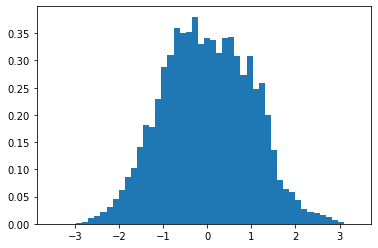

In [10]:
'''Apply standard scaling (zero mean and unit variance) to train and test data'''

X_train_norm = X_train.sub(mean).div(std)
# histogram to double check scaling is correct
_ = plt.hist(np.array(X_train_norm).ravel(), bins=50, density=True)

X_test_norm = X_test.sub(mean).div(std)
X_norm = torch.tensor(X).sub(mean).div(std)
subj_train.X_norm = X_norm # <-- note here we're saving the normalized data

print(X_train_norm.shape, X_test_norm.shape, X_norm.shape)

In [11]:
'''Convert data to pytorch dataloader for training'''
g_seed = torch.Generator()
g_seed.manual_seed(SEED)
batch_size = 128

train_data = TensorDataset(X_train_norm, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size,
                         shuffle=True, num_workers=4,
                         worker_init_fn=seed_worker,
                         generator=g_seed)

test_data = TensorDataset(X_test_norm, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size,
                         shuffle=True, num_workers=4,
                         worker_init_fn=seed_worker,
                         generator=g_seed)
print(f"# Batches: train {len(train_loader)}, eval {len(test_loader)}")

# Batches: train 320, eval 80


In [12]:
'''Used for testing model forward function'''
set_seed(SEED)
model = convVAE(3, 2, Encoder3L, Decoder3L)
model.to(DEVICE)
print("# Params: ", sum(p.numel() for p in model.parameters()))

# model.apply(init_weights)

for i, (x,_) in enumerate(test_loader):
    x = x.to(DEVICE)
    x_hat, z, elbo = model.loss(x, computeMSE=False)
    print(z.shape, x_hat.shape, elbo.item())
    print(model.result_dict)
    break

Random seed 2022 has been set.
# Params:  1641326
torch.Size([128, 2]) torch.Size([128, 256, 3]) 1445.5057373046875
{'loss_kl': 0.6738020777702332, 'loss_recon': 1444.83203125, 'loss_elbo': 1445.5057373046875}


# Training

- [Save torch models](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-state-dict-recommended)

In [14]:
'''Define model hyperparams'''

# Define model
embedding_dim = 2
model_type = '3L'
model = init_model(model_type, embedding_dim, SEED=SEED)
model.apply(init_weights)
print("# model params: ", sum(p.numel() for p in model.parameters()))

# Hyperparam
lr = 2e-4
wd = 1e-3
gradient_type = 'normal'
gradient_clip = 2.0

# Save path
model_setting = f"TESTconvVAE{model_type}_XUXU_Z{embedding_dim}_B{batch_size}_" \
                f"LR{lr:.0E}_WD{wd:.0E}_GC{gradient_type[0].upper()}{gradient_clip:.0E}"
model_name = f"{model_setting}_{subj_train.name}"
print(f"Saving to {model_name}")

Random seed 2022 has been set.
# model params:  1641326
Saving to TESTconvVAE3L_XUXU_Z2_B128_LR2E-04_WD1E-03_GCN2E+00_007_S_6120_20171117_A3_DWI_S127


In [15]:
'''For saving tensorboard log and model files'''

!mkdir {log_folder}{model_name}
!mkdir {model_folder}{model_name}
!mkdir {result_data_folder}{model_name}

mkdir: ../results/logs/TESTconvVAE3L_XUXU_Z2_B128_LR2E-04_WD1E-03_GCN2E+00_007_S_6120_20171117_A3_DWI_S127: File exists
mkdir: ../results/models/TESTconvVAE3L_XUXU_Z2_B128_LR2E-04_WD1E-03_GCN2E+00_007_S_6120_20171117_A3_DWI_S127: File exists
mkdir: ../results/data/TESTconvVAE3L_XUXU_Z2_B128_LR2E-04_WD1E-03_GCN2E+00_007_S_6120_20171117_A3_DWI_S127: File exists


In [16]:
'''Define training arguments'''

optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = wd)
writer = SummaryWriter(log_folder + model_name)

args = {
        'model' : model, 'optimizer' : optimizer, 
        'train_loader' : train_loader, 'test_loader': test_loader,
        'num_epochs' : 10, 'writer' : writer,
        'gradient_type' : gradient_type, 'gradient_clip' : gradient_clip,
        'computeMSE' : False, 'verbose' : writer,
        'save_every' : 4, 'save_folder' : model_folder + model_name, 
        'device' : DEVICE
       }

In [ ]:
'''Training'''

train_losses, eval_losses = train_model(**args)
writer.flush()
writer.close()

We could plot loss after training is finished, but using TensorBoard is recommend.

In [32]:
def plot_loss(losses, title, model_name, 
              smooth = 1, save_plot=True):
    
    n_plots = len(losses)
    fig, axes = plt.subplots(1, n_plots, figsize=(5*n_plots+1,5), sharey = False, sharex = True)

    for i, (k, v) in enumerate(losses.items()):
        if n_plots != 1:
            ax = axes[i]
        else:
            ax = axes
        v = np.mean(np.array(v).reshape(-1, smooth), axis=1)
        ax.plot(v)
        ax.set_title(f"{title} {k.split('_')[1].upper()} Loss")
        ax.set_xlabel('Batch')
    if save_plot:
        fig.savefig(f"{plot_folder}{model_name}_Loss_{title}_E{num_epochs}_S{smooth}.png")

In [ ]:
plot_loss(train_losses, "Train", model_name = model_name, smooth = 1, save_plot=True)
plot_loss(eval_losses, "Eval", model_name = model_name, smooth = 1, save_plot=True)

save_pickle(train_losses, f'{result_data_folder}{model_name}/train_losses')
save_pickle(eval_losses, f'{result_data_folder}{model_name}/eval_losses')